In [4]:
import sys

sys.path.append('..')

import os
import pickle
import random
from copy import deepcopy
from functools import partial
from itertools import islice
from os import environ
from pickle import dump

import matplotlib.pyplot as plt
import numpy as np
import wandb
from iteration_utilities import repeatfunc, unique_everseen
from sklearn.model_selection import train_test_split
from tokenizer import build_tokenizer
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from utils import train_collate_fn

from freegroup.sampling import CFGNormalClosureSampler, freegroup
from freegroup.sampling.helper import get_rng
from freegroup.tools import Comm, flatten, normalize, to_string

os.environ["TOKENIZERS_PARALLELISM"] = "false"

### Some preprocessing for unified format of data


In [7]:
def get_yn_label(label):
    label_dict = {
        'r': 'ynn',
        's': 'nyn',
        'c': 'yyy',
        'f': 'nnn',
        'i': 'yyn',
    }
    return label_dict[label]

In [8]:
def prepare_word(word, extend_mode=False, closures=None):
    label = get_yn_label(word['label']) + ':' 
    output_dict = {}
    output_dict['closures'] = closures if closures else word['closures']
    if extend_mode:
        closures = ','.join([closure for closure in word['closures']]) + ':'
        word_str = label + closures + word['word_str']
    else:
        word_str = label + word['word_str']

    output_dict['word_str'] = word_str
    output_dict['label'] = word['label']
    return output_dict

def prepare_words(words, **kwargs):
    return [prepare_word(word, **kwargs) for word in words]

In [4]:
# tokenizer.decode(tokenizer('-1 1')['input_ids'], skip_special_tokens=True) # HOWTO use tokenizer
# to_string([1, -3, 1])

In [5]:
# root = '/main'
# samplers_path = f'{root}/draft-v2/data/CFG_samplers/toy_whitehead_n_3_L_50.pkl'
# with open(samplers_path, 'rb') as file:
#     samplers = pickle.load(file)
# R, S = samplers

### Auxilary functions for fast check-ups

In [10]:
letter2int = {
    'x': 1,
    'X': -1,
    'y': 2,
    'Y': -2,
    'z': 3,
    'Z': -3
}

def string2list_int(word: str):
    return [letter2int[letter] for letter in word]

### Params for dataset generation

In [12]:
seed = 0
rng = get_rng(seed)

# free group rank
fdim = 3
# words that generate normal closures : r = a^3, s=[a,b]
# r = [1, 1, 1] # group connections (can be other)
# s = [-1, -2, 1, 2] # group connections (can be other)

# closures = [
#     [[1,1,1], [-1,-2,1,2]],
#     [[1,1,2], [-1,2,2]],
#     [[2,2,2,2], [1,2,1]],
#     [[2,2], [1,1]]
# ]


# ZXzYXyZXzyZ, ZxzxzXY
# closure_sets = [
#     [[-3, -1, 3, -2, -1, 2, -3, -1, 3, 2, -3], [-3, 1, 3, 1, 3, -1, -2, 1], [-1, 2, 2, 2, -3]],
#     [[-3, -1, 3, -2, -1, 2, -3, -1, 3, 2, -3], [-3, 1, 3, 1, 3, -1, -2, 1], [-1, 2, 2, 2, -3, 1, -2]],
#     [[-3, -1, 3, -2, -1, 2, -3, -1, 3, 2, -3], [-3, 1, 3, 1, 3, -1, -2, 1], [-1, 2, 3]]

# ]
# r = [-1, 2, 2, 1, -2, -2, -2]
# s = [-2, 1, 1, 2, -1, -1, -1]
    # [[-1, 2, 1, -2, -2], [-1, -1, -2, 1, 1, 2]]
# max length
r = [-1, 2, 2, 2, -3]
s = [-3, 1, 3, 1, 3, -1, -2, 1]
# L = 50
# train dataset size
# N = int(2e5)

In [13]:
tokenizer = build_tokenizer(
    "word-level",
    fdim=fdim,
    add_commutator_tokens=True,
    add_prompt_tokens=True,
    add_post_processor=True,
)

/usr/local/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [14]:
L = 100

In [15]:
samplers = [CFGNormalClosureSampler.build(closure=closure, fdim=fdim, max_length=L) for closure in tqdm([r, s])]

In [26]:
with open(f'/main/whitehead/data/CFG_samplers/sampler_{",".join(map(str, s))}_L={L}.pkl', 'wb') as f:
    pickle.dump(samplers[1], f)

### Sampler funtions

In [27]:
def sample(sampler, label, n_samples=int(1e3), rng=rng):
    """
    return a list of samples for certain sampler
    """
    def fn():             
        length = rng.integers(1, L + 1)
        try:
            word = sampler(length=length, rng=rng)
            return {
                "word_str" : to_string(word),
                "label": label,
                }
        except:
            return None
        
    # some itertools magic to exclude duplicates and handle exceptions of samplers
    iterator = repeatfunc(fn) 
    iterator = filter(lambda x: x is not None, iterator)
    iterator = unique_everseen(iterator)
    iterator = islice(iterator, n_samples)

    return list(tqdm(iterator, total=n_samples))

In [28]:
def sample_freegroup(fdim=2, n_samples=int(1e3), rng=rng):
    label = 'f'
    def fn():
        length = rng.integers(1, L + 1)
        word = freegroup(fdim, length, rng=rng)
        return {
            "word_str" : to_string(word),
            "label": label,
            }
    iterator = repeatfunc(fn)
    iterator = unique_everseen(iterator)
    iterator = islice(iterator, n_samples)

    return list(tqdm(iterator, total = int(n_samples)))

In [29]:
def sample_comm(samplers, n_samples=int(1e3), rng=rng):
    label = 'c'
    def fn():
        words = []
        for sampler in samplers:
            flag = False
            while not flag:
                length = rng.integers(1, L // 3)
                try:
                    word = sampler(length=length, rng=rng)
                    words.append(word)
                    flag = True
                except KeyboardInterrupt:
                    break
                except ValueError:
                    pass
                
        coin = rng.integers(low = 0, high = 2)
        if coin:
            result = flatten(Comm(words))
        else:
            result = flatten(Comm(words[::-1]))

        return {
            "word_str": to_string(result),
            "label": label
                    }


    iterator = repeatfunc(fn)
    iterator = unique_everseen(iterator)
    iterator = islice(iterator, n_samples)

    return list(tqdm(iterator, total = int(n_samples)))

In [ ]:
def sample_comm_from_data(data, n_samples=int(1e3), rng=rng):
    label = 'c'
    # n_relations = len(data)
    def str2int(x):
        return list(map(int, x['word_str'].split()))

    parsed_data = [list(map(str2int, words)) for words in data]
    parsed_data = [list(filter(lambda x: len(x) < L // 3, words)) for words in parsed_data]

    def fn():
        words_ = [random.choice(words) for words in parsed_data]

        coin = rng.integers(low = 0, high = 2)
        if coin:
            result = normalize(flatten(Comm(words_)))
        else:
            result = normalize(flatten(Comm(words_[::-1])))

        return {
            "word_str": to_string(result),
            "label": label
                    }


    iterator = repeatfunc(fn)
    iterator = unique_everseen(iterator)
    iterator = islice(iterator, n_samples)

    return list(tqdm(iterator, total=int(n_samples)))

### Generate data

In [ ]:
N = int(2e5)

In [ ]:
r_data = sample(n_samples=N, sampler=samplers[0], label='r')
s_data = sample(n_samples=N, sampler=samplers[1], label='s')

In [ ]:
c_data = sample_comm_from_data([r_data, s_data], n_samples=N) # lengths are controlled inside the function
f_data = sample_freegroup(fdim=fdim, n_samples=N)

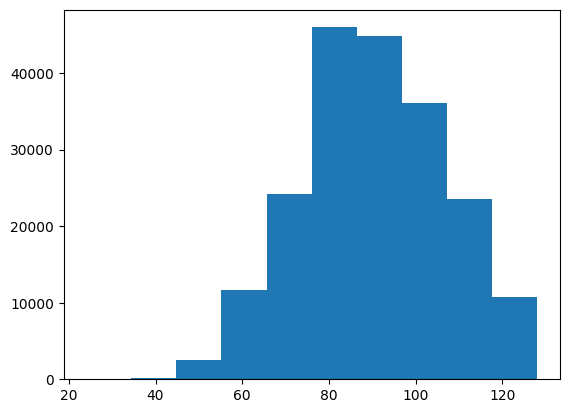

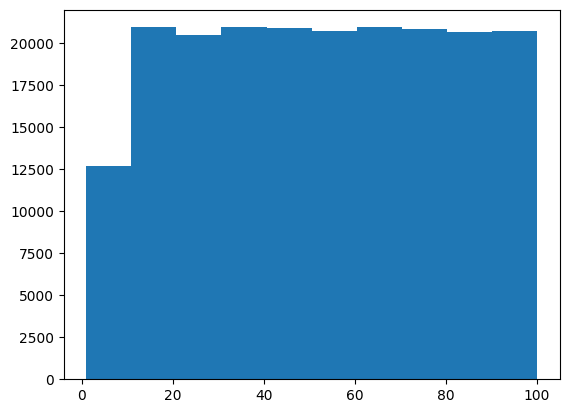

In [139]:
plt.hist(list(map(lambda x: len(x['word_str'].split()), c_data)))
plt.show()
plt.hist(list(map(lambda x: len(x['word_str'].split()), f_data)))
plt.show()

In [146]:
dataset_1 = r_data + s_data + f_data + s_data

### Prepare test prefixes

In [150]:
unique_prefixes_3 = set(filter(lambda x: len(x.split()) == 3, map(lambda x: to_string(x['word_str'].split()[:3]), dataset_1)))
test = [
    {
        'word_str': prefix,
        'label': 'i',
        'closures': [to_string(r), to_string(s)]
     } for prefix in unique_prefixes_3
]

In [ ]:
test_processed = prepare_words(test)

In [140]:
r_data_prepared = prepare_words(r_data, closures=[to_string(r), to_string(s)])
s_data_prepared = prepare_words(s_data, closures=[to_string(r), to_string(s)])
f_data_prepared = prepare_words(f_data, closures=[to_string(r), to_string(s)])
c_data_prepared = prepare_words(c_data, closures=[to_string(r), to_string(s)])

In [145]:
dataset = r_data_prepared + s_data_prepared + c_data_prepared + f_data_prepared

#### Check-ups (draft)

In [488]:
test_closure = r # list(map(int, closures[0].split()))
test_word = list(map(int, dataset[100000*2]['word_str'].split()))
magnus_is_from_normal_closure(test_word, test_closure)

False

In [ ]:
# multi_closure_dataset = []
# for sampler_pair in (samplers[:n_pairs]):
#     R, S = sampler_pair
#     connections = [to_string(R._closure), to_string(S._closure)]
#     dataset_r = sample(n_samples=N // 4, sampler=R, label='r')
#     dataset_s = sample(n_samples=N // 4, sampler=S, label='s')
#     dataset_f = sample_freegroup(n_samples=N // 4)
#     dataset_c = sample_comm(n_samples=N // 4,  samplers=(R, S))
#     dataset = dataset_r + dataset_s + dataset_f + dataset_c
#     for el in dataset:
#         el['connections'] = connections
#     multi_closure_dataset.extend(dataset)

In [ ]:
# train, test = train_test_split(
#     deepcopy(dataset),
#     test_size=0.1,
#     stratify=list(map(lambda x: x['label'], dataset))
#     )

In [ ]:
# for el in dataset:
#     el['closures'] = closures
# dataset = prepare_words(dataset)
# for el in test:
#     el['closures'] = closures
#     el['label'] = 'i'
#     el['word_str'] = ' '.join(el['word_str'].split()[:3])
# test = prepare_words(test)


In [153]:
from freegroup.tools import from_string

In [152]:
def train_collate_fn(batch, tokenizer):
    batch = [el['word_str'] for el in batch]
    batch = tokenizer(batch, padding=True, return_tensors='pt', return_token_type_ids=False)
    batch['labels'] = batch['input_ids'].clone()
    batch['labels'][batch['attention_mask'] == 0] = -100
    return batch

In [154]:
def inference_collate_fn(batch_, tokenizer):
    closures = [el['closures'] for el in batch_]
    batch = [el['word_str'] for el in batch_]
    batch = tokenizer(batch, padding=False, return_tensors='pt',
                      return_token_type_ids=False, padding_side='left')
    batch['input_ids'] = batch['input_ids'][:, :-1] # delete eof
    batch['attention_mask'] = batch['attention_mask'][:, :-1]
    batch['closures'] = closures#list(zip(*closures))
    # for i in range(len(batch['closures'])):
    #     batch['closures'][i] = list(map(from_string, batch['closures'][i]))
    return batch

In [536]:
# multi_closure_dataset_processed = prepare_sentences(multi_closure_dataset)

In [537]:
# """make test samples with short length and intersection label (i)"""
# for i in range(len(test)):
#     test[i]['sentence'] = 'yyn' + test[i]['sentence'][3:]
#     test[i]['label'] = 'i'

In [155]:
from utils import multi_ratios_collate_fn, multi_ratios_collate_fn_inference
train_dl = DataLoader(dataset, 2, collate_fn=partial(train_collate_fn, tokenizer=tokenizer)) # What is dataloader
test_dl = DataLoader(test_processed, 2, collate_fn=partial(inference_collate_fn, tokenizer=tokenizer)) # What is dataloader

# !!!ATTENTION!!! it's a coincidence that train_collate_fn (old) with fdim=2 is suitable for whitehead problem.
# In general this method should be adapted for certain prompt label size (now the size is [1: 1 + fdim + 1 + 1], i.e. fdim + 2 size)

In [435]:
magnus_is_from_normal_closure([-3, -1, 3, -2, -1, 2, -3, -1, 3, 2, -3], [-1, 3, -2, -1, 2, -3, -1, 3, 2, -3])

False

In [156]:
el = next(iter(test_dl))
el.keys()

dict_keys(['input_ids', 'attention_mask', 'closures'])

In [157]:
el['closures']

[['-1 2 2 2 -3', '-3 1 3 1 3 -1 -2 1'], ['-1 2 2 2 -3', '-3 1 3 1 3 -1 -2 1']]

In [158]:
[[b for b in a] for a in el['closures']]

[['-1 2 2 2 -3', '-3 1 3 1 3 -1 -2 1'], ['-1 2 2 2 -3', '-3 1 3 1 3 -1 -2 1']]

In [159]:
[[from_string(b) for b in a] for a in el['closures']][0]

[[-1, 2, 2, 2, -3], [-3, 1, 3, 1, 3, -1, -2, 1]]

In [162]:
from freegroup.tools import magnus_reduce_modulo_normal_closure
magnus_reduce_modulo_normal_closure(list(map(int, dataset_1[200003]['word_str'].split())), s) # Проверка

[]

# LOG TO WANDB

In [235]:
environ['WANDB_USERNAME']='pavel-tikhomirov'
environ['WANDB_DIR']=f'/main/whitehead/{environ["WANDB_USERNAME"]}-runs/'
environ['TOKENIZERS_PARALLELISM']='false'

In [236]:
run = wandb.init(entity='ml-in-algebraic-topology', project='whitehead', job_type='build-dataset')

wandb: Currently logged in as: pavel-tikhomirov (ml-in-algebraic-topology). Use `wandb login --relogin` to force relogin


In [241]:
data = wandb.Artifact(f'fdim-{fdim}-whitehead', type='dataset',
                      description=f'fdim={fdim}. 2-relation with relations {str([r, s])}, freegroup and commutator (of 2). Balanced train part, Disbalanced validation part. 150 unique test prefixes of size 3. Comutator of sampled words. Fix bug with normalize comutator',
                      metadata={
                              'fdim': fdim,
                              'N': len(balance_dataset_train),
                              'max_length': balanced_dataset.word_len.max(),
                              'min_length': balanced_dataset.word_len.min()
                          }
    )
with data.new_file('train.pkl', 'wb') as file:
        dump(prepare_words(balance_dataset_train), file)
with data.new_file('val.pkl', 'wb') as file:
        dump(prepare_words(balance_dataset_test), file)
with data.new_file('test.pkl', 'wb') as file:
        dump(test_processed, file)
run.log_artifact(data)

<Artifact fdim-3-whitehead>

In [242]:
wandb.finish()

# DOWNLOAD FROM WANDB

In [501]:
import sys

sys.path.append('..')
import pickle
from os import environ
from pathlib import Path

import wandb
from lming.utils import download_artifact

In [502]:
environ['WANDB_USERNAME']='pavel-tikhomirov'
environ['WANDB_DIR']=f'/main/whitehead/{environ["WANDB_USERNAME"]}-runs/'
environ['TOKENIZERS_PARALLELISM']='false'

In [526]:
run = wandb.init(entity='ml-in-algebraic-topology', project='whitehead')
artifact_dir = download_artifact('fdim-3-whitehead:v1')

wandb:   2 of 2 files downloaded.  


In [527]:
wandb.finish()

In [528]:
with open(Path(artifact_dir) / "train.pkl", 'rb') as f:
    data = pickle.load(f)

# PREPARE DATA FOR CLASSIFIER

In [ ]:
r_data_parsed = list(map(tmp_func, r_data)) # make just list of lists
s_data_parsed = list(map(tmp_func, s_data))
c_data_parsed = list(map(tmp_func, c_data))

In [182]:
f_data_parsed = list(map(tmp_func, f_data))

In [171]:
import seaborn as sns

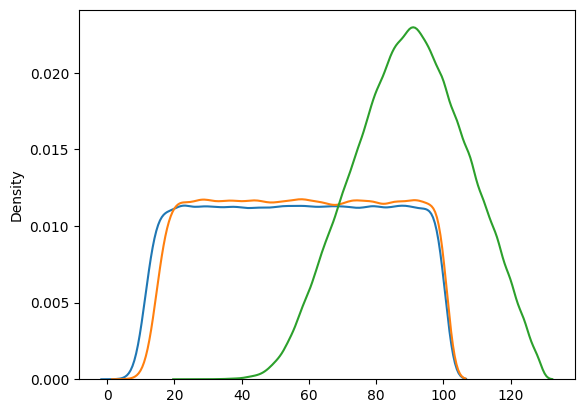

In [172]:
sns.kdeplot(list(map(len, r_data_parsed)))
sns.kdeplot(list(map(len, s_data_parsed)))
sns.kdeplot(list(map(len, c_data_parsed)))
plt.show()

In [173]:
import pandas as pd

In [177]:
r_df = pd.DataFrame({'word': r_data_parsed})
r_df['word_len'] = r_df['word'].apply(len)

In [180]:
s_df = pd.DataFrame({'word': s_data_parsed})
s_df['word_len'] = s_df['word'].apply(len)
c_df = pd.DataFrame({'word': c_data_parsed})
c_df['word_len'] = c_df['word'].apply(len)

In [183]:
f_df = pd.DataFrame({'word': f_data_parsed})
f_df['word_len'] = f_df['word'].apply(len)

In [184]:
r_df['label'] = 'r'
s_df['label'] = 's'
f_df['label'] = 'f'
c_df['label'] = 'c'

In [181]:
c_df.word_len.value_counts()

word_len
90     9244
92     9231
94     8897
88     8865
86     8793
96     8661
84     8437
98     8096
100    7964
82     7833
80     7588
102    7034
78     6997
104    6914
76     6331
106    6061
108    5991
74     5946
72     5281
110    4961
70     4931
112    4760
68     4251
114    4038
116    3851
66     3824
64     3383
118    2905
62     2786
120    2742
60     2249
58     1928
122    1839
124    1696
56     1344
54     1022
126     867
128     725
52      640
50      460
48      269
46      141
44       92
42       64
40       24
38       21
36       11
34        5
32        3
26        2
24        1
30        1
Name: count, dtype: int64

In [179]:
r_df.word_len.value_counts()

word_len
23    2375
71    2341
89    2329
33    2329
68    2322
      ... 
11     898
10     258
9      200
7       40
5       10
Name: count, Length: 94, dtype: int64

In [186]:
import pandas as pd

def balance_datasets(r_df, s_df, f_df, c_df):
    # Initialize an empty DataFrame to hold the final balanced dataset
    balanced_df = pd.DataFrame(columns=r_df.columns)

    # Get the set of unique word lengths from r_df
    unique_lengths = r_df['word_len'].unique()

    # Iterate over each unique word length
    for word_len in unique_lengths:
        # Find the number of occurrences for this word length in each dataframe
        r_count = len(r_df[r_df['word_len'] == word_len])
        s_count = len(s_df[s_df['word_len'] == word_len])
        f_count = len(f_df[f_df['word_len'] == word_len])
        c_count = len(c_df[c_df['word_len'] == word_len])

        # Calculate the minimum count (only consider non-zero counts)
        min_count = min(x for x in [r_count, s_count, f_count, c_count])

        # If any of the dataframes have no words of this length, skip this length
        if min_count == 0:
            continue

        # Sample min_count instances for the current word length from each dataframe
        sampled_r = r_df[r_df['word_len'] == word_len].sample(n=min_count, random_state=42)
        sampled_s = s_df[s_df['word_len'] == word_len].sample(n=min_count, random_state=42)
        sampled_f = f_df[f_df['word_len'] == word_len].sample(n=min_count, random_state=42)
        sampled_c = c_df[c_df['word_len'] == word_len].sample(n=min_count, random_state=42)

        # Append the sampled dataframes to the balanced dataframe
        balanced_df = pd.concat([balanced_df, sampled_r, sampled_s, sampled_f, sampled_c], ignore_index=True)

    return balanced_df

# Example usage
# r_df, s_df, f_df, c_df need to be defined/loaded before calling the function
balanced_dataset = balance_datasets(r_df, s_df, f_df, c_df)

In [200]:
balanced_dataset.loc[:, 'word'] = balanced_dataset['word'].apply(str)

In [195]:
big_dataset = pd.concat([r_df, s_df, f_df, c_df], ignore_index=True)

In [201]:
big_dataset.loc[:, 'word'] = big_dataset['word'].apply(str)

In [204]:
merged_data = big_dataset.merge(balanced_dataset, how='left', on='word').drop(columns='word_len_y')

In [206]:
merged_data['test'] = merged_data.label_y.isna()

In [211]:
merged_data[~merged_data.test].word_len_x

6         68
21        66
22        58
24        76
25        78
          ..
799988    88
799990    70
799992    96
799997    80
799998    54
Name: word_len_x, Length: 199156, dtype: int64

In [213]:
merged_data.loc[:, 'word'] = merged_data.word.apply(eval)

In [ ]:
test = [
    {
        'word_str': prefix,
        'label': 'i',
        'closures': [to_string(r), to_string(s)]
     } for prefix in unique_prefixes_3
]

In [218]:
def pd2dict(word, label):
    return {
        'word_str': to_string(word),
        'label': label,
        'closures': [to_string(r), to_string(s)]
     }

In [221]:
tqdm.pandas()

In [222]:
for label in 'rsfc':
    merged_data.loc[merged_data.label_x==label, 'dataset'] = merged_data[merged_data.label_x==label].word.progress_apply(partial(pd2dict, label=label))

  0%|          | 0/200000 [00:00<?, ?it/s]

  0%|          | 0/200000 [00:00<?, ?it/s]

  0%|          | 0/200000 [00:00<?, ?it/s]

  0%|          | 0/200000 [00:00<?, ?it/s]

In [230]:
balance_dataset_test = merged_data[merged_data.test].dataset.values.tolist()
balance_dataset_train = merged_data[~merged_data.test].dataset.values.tolist()

In [234]:
prepare_words(balance_dataset_train)

[{'closures': ['-1 2 2 2 -3', '-3 1 3 1 3 -1 -2 1'],
  'word_str': 'ynn:-2 -3 1 2 -3 -1 2 2 -1 3 -1 3 -1 -1 -3 -1 2 2 2 1 1 3 -2 -2 -2 3 -1 -1 -2 1 3 -2 -2 1 1 -3 1 -2 -2 -2 1 -3 -1 -3 -1 2 2 2 1 3 -2 -3 1 3 -2 -2 -2 3 2 2 3 -2 -2 -2 1 -2 1 2',
  'label': 'r'},
 {'closures': ['-1 2 2 2 -3', '-3 1 3 1 3 -1 -2 1'],
  'word_str': 'ynn:-3 -1 2 2 1 -2 -2 1 3 -2 -1 3 3 2 -3 -1 2 2 -3 -3 -2 -2 -2 -3 2 -3 -1 3 -2 -2 -2 1 1 -3 2 2 -3 -1 2 3 -1 2 2 3 2 3 -2 1 3 -2 3 -1 2 2 2 1 3 -2 -2 -2 -3 -3 -2 -3 1 3',
  'label': 'r'},
 {'closures': ['-1 2 2 2 -3', '-3 1 3 1 3 -1 -2 1'],
  'word_str': 'ynn:-2 -2 -3 2 -3 2 1 3 1 -3 2 -3 -1 -3 1 3 1 -2 -3 -3 2 -3 -1 2 2 3 3 2 -1 -3 -1 3 2 2 3 -1 -2 -2 -2 -2 -1 2 2 3 3 2 2 -3 2 2 -3 -1 2 -1 2 -3 2 2',
  'label': 'r'},
 {'closures': ['-1 2 2 2 -3', '-3 1 3 1 3 -1 -2 1'],
  'word_str': 'ynn:3 -1 -1 -1 -2 3 -2 -2 1 3 -2 -1 3 -2 -1 3 -1 2 1 1 2 2 1 -3 -1 2 2 2 -1 2 -3 -1 -1 -1 -2 1 -2 -2 -3 -3 1 2 2 -3 -1 2 -1 3 -2 1 -2 -1 -2 -2 -2 1 3 1 2 3 -2 -2 3 2 2 -3 1 2 -3 1 

In [233]:
test_processed

[{'closures': ['-1 2 2 2 -3', '-3 1 3 1 3 -1 -2 1'],
  'word_str': 'yyn:2 1 1',
  'label': 'i'},
 {'closures': ['-1 2 2 2 -3', '-3 1 3 1 3 -1 -2 1'],
  'word_str': 'yyn:-3 2 1',
  'label': 'i'},
 {'closures': ['-1 2 2 2 -3', '-3 1 3 1 3 -1 -2 1'],
  'word_str': 'yyn:-1 3 1',
  'label': 'i'},
 {'closures': ['-1 2 2 2 -3', '-3 1 3 1 3 -1 -2 1'],
  'word_str': 'yyn:2 -3 1',
  'label': 'i'},
 {'closures': ['-1 2 2 2 -3', '-3 1 3 1 3 -1 -2 1'],
  'word_str': 'yyn:3 2 3',
  'label': 'i'},
 {'closures': ['-1 2 2 2 -3', '-3 1 3 1 3 -1 -2 1'],
  'word_str': 'yyn:-2 -3 -1',
  'label': 'i'},
 {'closures': ['-1 2 2 2 -3', '-3 1 3 1 3 -1 -2 1'],
  'word_str': 'yyn:-2 3 1',
  'label': 'i'},
 {'closures': ['-1 2 2 2 -3', '-3 1 3 1 3 -1 -2 1'],
  'word_str': 'yyn:-1 -2 -1',
  'label': 'i'},
 {'closures': ['-1 2 2 2 -3', '-3 1 3 1 3 -1 -2 1'],
  'word_str': 'yyn:3 3 -1',
  'label': 'i'},
 {'closures': ['-1 2 2 2 -3', '-3 1 3 1 3 -1 -2 1'],
  'word_str': 'yyn:2 1 -3',
  'label': 'i'},
 {'closures': ['-1

In [232]:
balance_dataset_train

[{'word_str': '-2 -3 1 2 -3 -1 2 2 -1 3 -1 3 -1 -1 -3 -1 2 2 2 1 1 3 -2 -2 -2 3 -1 -1 -2 1 3 -2 -2 1 1 -3 1 -2 -2 -2 1 -3 -1 -3 -1 2 2 2 1 3 -2 -3 1 3 -2 -2 -2 3 2 2 3 -2 -2 -2 1 -2 1 2',
  'label': 'r',
  'closures': ['-1 2 2 2 -3', '-3 1 3 1 3 -1 -2 1']},
 {'word_str': '-3 -1 2 2 1 -2 -2 1 3 -2 -1 3 3 2 -3 -1 2 2 -3 -3 -2 -2 -2 -3 2 -3 -1 3 -2 -2 -2 1 1 -3 2 2 -3 -1 2 3 -1 2 2 3 2 3 -2 1 3 -2 3 -1 2 2 2 1 3 -2 -2 -2 -3 -3 -2 -3 1 3',
  'label': 'r',
  'closures': ['-1 2 2 2 -3', '-3 1 3 1 3 -1 -2 1']},
 {'word_str': '-2 -2 -3 2 -3 2 1 3 1 -3 2 -3 -1 -3 1 3 1 -2 -3 -3 2 -3 -1 2 2 3 3 2 -1 -3 -1 3 2 2 3 -1 -2 -2 -2 -2 -1 2 2 3 3 2 2 -3 2 2 -3 -1 2 -1 2 -3 2 2',
  'label': 'r',
  'closures': ['-1 2 2 2 -3', '-3 1 3 1 3 -1 -2 1']},
 {'word_str': '3 -1 -1 -1 -2 3 -2 -2 1 3 -2 -1 3 -2 -1 3 -1 2 1 1 2 2 1 -3 -1 2 2 2 -1 2 -3 -1 -1 -1 -2 1 -2 -2 -3 -3 1 2 2 -3 -1 2 -1 3 -2 1 -2 -1 -2 -2 -2 1 3 1 2 3 -2 -2 3 2 2 -3 1 2 -3 1 -3 2 1 1 1 -3',
  'label': 'r',
  'closures': ['-1 2 2 2 -3', '-3 1 3